<a href="https://colab.research.google.com/github/louiskrisdy/Mental-Health-Chatbot/blob/main/Mental_Health_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load Google Drive** ##
We will save our model and certain file(s) here and we take the dataset file from GDrive. Make sure to give the permission to connect to our Gdrive and give the permission.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Voice Recognition Library Installation** #

**Speech Recognition** and **Google Text To Speech**

In [2]:
!pip -q install speechrecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 45.3 MB/s eta 0:00:00


In [3]:
!pip -q install gtts

# **Import Library** #


In [4]:
# Import Libraries
import json
import nltk
import pickle
import random
import string
import time
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

# **Download NLTK Package** #

In [6]:
# Package for sentence tokenizer
nltk.download('punkt')

# Package for lemmatization
nltk.download('wordnet')

# Package for multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Get the dataset** #

In [7]:
# Importing the dataset *Make sure we have the dataset in our Gdrive*
# https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data
with open('./mhdataset.json') as content:
  temp_data = json.load(content)

# Get all the data to the list
tags = [] # data tag
inputs = [] # data input or pattern
responses = {} # data response
words = [] # Data words
classes = [] # Data class or tag
documents = [] # Data document sentence
ignore_words = ['?', '!'] # Neglect the special character signs

for intent in temp_data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Convert the json data into dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [9]:
# Check all the data
data

,patterns,tags
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting
...,...,...
227,How do I know if I'm unwell?,fact-29
228,How can I maintain social connections? What if...,fact-30
229,What's the difference between anxiety and stress?,fact-31
230,What's the difference between sadness and depr...,fact-32


In [10]:
data.head()

,patterns,tags
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting


In [11]:
data.tail()

,patterns,tags
227,How do I know if I'm unwell?,fact-29
228,How can I maintain social connections? What if...,fact-30
229,What's the difference between anxiety and stress?,fact-31
230,What's the difference between sadness and depr...,fact-32
231,difference between sadness and depression,fact-32


In [13]:
# Checking if there is missing value(s)
data.isna().sum()

patterns    0
tags        0
dtype: int64

# **Preprocessing**

## **Remove Punctuations**



In [14]:
# Removing Punctuations
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

## **Lemmatization**



In [15]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

297 unique lemmatized words ["'ll", "'m", "'re", "'s", "'ve", ',', '.', 'a', 'about', 'absolutely', 'advice', 'affect', 'afternoon', 'again', 'all', 'alot', 'already', 'am', 'and', 'another', 'answer', 'anxiety', 'anxious', 'any', 'anymore', 'anyone', 'anything', 'appears', 'approaching', 'are', 'ask', 'au', 'available', 'away', 'awful', 'be', 'because', 'become', 'before', 'better', 'between', 'bonjour', 'boyfriend', 'break', 'bring', 'brother', 'burned', 'by', 'bye', 'ca', 'call', 'can', 'cause', 'cheerful', 'child', 'commit', 'connection', 'continue', 'control', 'could', 'crazy', 'created', 'cure', 'dad', 'day', 'define', 'depressed', 'depression', 'deserve', 'did', 'die', 'died', 'difference', 'different', 'disorder', 'do', 'doe', 'down', 'dumb', 'else', 'empty', 'enough', 'evening', 'exam', 'fact', 'family', 'fare', 'feel', 'feeling', 'few', 'financial', 'find', 'fine', 'focus', 'for', 'friend', 'from', 'get', 'girlfriend', 'give', 'go', 'going', 'good', 'goodbye', 'great', 'group

### **Sorting Data of Class Tags**

In [16]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

80 classes ['about', 'afternoon', 'anxious', 'ask', 'casual', 'creation', 'death', 'default', 'depressed', 'done', 'evening', 'fact-1', 'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15', 'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-2', 'fact-20', 'fact-21', 'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27', 'fact-28', 'fact-29', 'fact-3', 'fact-30', 'fact-31', 'fact-32', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9', 'friends', 'goodbye', 'greeting', 'happy', 'hate-me', 'hate-you', 'help', 'jokes', 'learn-mental-health', 'learn-more', 'location', 'meditation', 'mental-health-fact', 'morning', 'name', 'neutral-response', 'night', 'no-approach', 'no-response', 'not-talking', 'pandora-useful', 'problem', 'repeat', 'sad', 'scared', 'skill', 'sleep', 'something-else', 'stressed', 'stupid', 'suicide', 'thanks', 'understand', 'user-advice', 'user-agree', 'user-meditation', 'worthless', 'wrong']


### **Total Text Data**

In [18]:
# documents = combination between patterns and intents
print (len(documents), "documents")

1148 documents


## **Tokenization**



In [19]:
# Tokenize the data
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[95],
 [96],
 [14, 97, 41],
 [95, 41],
 [151],
 [96, 41],
 [152],
 [153],
 [154],
 [155],
 [156, 157],
 [158],
 [42, 159],
 [42, 160],
 [42, 161],
 [42, 162],
 [68],
 [98, 2, 163],
 [164],
 [165, 166],
 [167],
 [51, 68],
 [68, 168],
 [169, 170, 99],
 [100],
 [69, 2],
 [70, 171],
 [100, 18, 19, 32],
 [172, 2, 71, 52],
 [],
 [72, 52],
 [33, 12, 2],
 [3, 12, 2],
 [33, 2, 12],
 [34, 7, 35, 6, 73],
 [3, 14, 74, 53],
 [3, 75, 1, 173, 2],
 [76, 74, 53],
 [34, 7, 6, 73],
 [3, 10, 2, 13],
 [33, 101, 2],
 [24, 102, 2, 174],
 [24, 102, 2, 101],
 [15, 53, 14],
 [1, 9, 53],
 [1, 54, 175],
 [103, 2, 32, 7],
 [176, 7, 16, 177, 104],
 [10, 2, 32],
 [3, 10, 2, 13, 18, 7],
 [1, 36, 77],
 [1, 36, 32],
 [77, 7, 104],
 [1, 9, 178, 55],
 [1, 9, 20, 55],
 [1, 11, 179],
 [1, 11, 105],
 [1, 9, 105],
 [1, 11, 20, 55],
 [1, 11, 180],
 [1, 17, 21, 97],
 [1, 9, 20, 56, 78],
 [1, 9, 20, 56],
 [1, 11, 181],
 [1, 182, 11, 56],
 [1, 9, 20, 183, 78],
 [1, 11, 20, 184],
 [43, 185, 186, 7],
 [1, 28, 13, 106],
 [1, 9, 20

## **Padding**




In [23]:
# Apply padding
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0  95]
 [  0   0   0 ...   0   0  96]
 [  0   0   0 ...  14  97  41]
 ...
 [  0   0   0 ... 301  49 302]
 [  0   0   0 ... 150  49  30]
 [  0   0   0 ... 150  49  30]]


## **Encoding Text**


In [21]:
# data['tags']

0      greeting
1      greeting
2      greeting
3      greeting
4      greeting
         ...   
227     fact-29
228     fact-30
229     fact-31
230     fact-32
231     fact-32
Name: tags, Length: 232, dtype: object

In [24]:
# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[44 44 44 44 44 44 44 44 44 44 44 44 55  1 10 58 43 43 43 43 43 43 43 43
 73 73 73 73 73 60 57  0  0  0  0  0  0  0  0 67  5  5  5 56 56 56 48 48
 48 48 48 48 48 65 65 65 65 65 65 65 65 70 70 70 70 70 78 78 78 78 78  8
  8  8  8 45 45 45 45 45 45 45  4  4  4  4  4  4  4  4  4  4  4  2  2 61
 61 61 61 68 68 68 68 68 68 66 66 66 66  6  6  6  6  6  6 74 74 74 74 74
 74  9  9  9  9  9 72 72 72 72 72 47 47 47 46 46 46  7  7  7  7  7  7  7
  7 49 49 64 64 64 79 79 79 79 71 71 71 71 52 52 52 69 69 69 69 42  3 63
 63 59 59 59 51 51 51 76 76 53 53 77 77 62 75 75 75 50 50 50 54 54 11 11
 22 22 33 33 37 37 37 37 38 38 39 39 39 40 41 12 13 14 15 16 17 18 19 20
 21 23 24 25 26 27 28 29 29 30 31 32 34 35 36 36]


# **Input Length, Output Length and Vocabulary**

In [25]:
# Input length
# Value of input_shape indicating that the input sequences have a length of __ tokens after padding,
# which will be the input shape used for model definition and training.

input_shape = x_train.shape[1]
print(input_shape)

18


In [27]:
# Define vocabulary
vocabulary = len(tokenizer.word_index) # Calculates the length of the word index, which represents the number of unique words in the vocabulary.
print("number of unique words : ", vocabulary)

# Output length
output_length = le.classes_.shape[0] #  contains the unique classes or labels encoded using LabelEncoder
print("output length: ", output_length)

number of unique words :  302
output length:  80


## **Save Model Words & Classes**
It is typically used to establish a model's relationship that has been trained with a text processing model.



In [29]:
pickle.dump(words, open('/content/drive/MyDrive/Project/NLP/Chatbot/Model/words.pkl','wb'))
pickle.dump(classes, open('/content/drive/MyDrive/Project/NLP/Chatbot/Model/classes.pkl','wb'))

## **Save Label Encoder & Tokenizer**

In [30]:
pickle.dump(le, open('/content/drive/MyDrive/Project/NLP/Chatbot/Model/le.pkl','wb'))
pickle.dump(tokenizer, open('/content/drive/MyDrive/Project/NLP/Chatbot/Model/tokenizers.pkl','wb'))

# **Neural Network Model**



In [31]:
# Creating the model
i = Input(shape=(input_shape,)) # Defines the input layer with the shape (input_shape,). This layer specifies the shape of the input data the model will receive.
x = Embedding(vocabulary+1,10)(i) # Creates an embedding layer. It maps input indices (words) into fixed-size dense vectors.
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Flattens the output from the LSTM layer into a one-dimensional tensor. This prepares the data for the subsequent fully connected layers.
x = Dense(output_length, activation="softmax")(x) # Adds a fully connected dense layer as the output layer.
model  = Model(i,x) # This line constructs a Keras Model by specifying the input and output layers.

# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

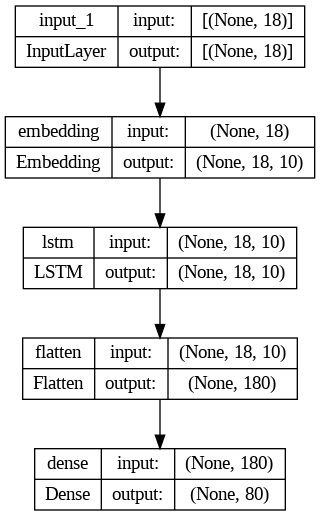

In [32]:
# Visualization Plot Architecture Model
plot_model(model, to_file='/content/drive/MyDrive/Project/NLP/Chatbot/model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
# Showing Parameter Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding (Embedding)       (None, 18, 10)            3030      
                                                                 
 lstm (LSTM)                 (None, 18, 10)            840       
                                                                 
 flatten (Flatten)           (None, 180)               0         
                                                                 
 dense (Dense)               (None, 80)                14480     
                                                                 
Total params: 18350 (71.68 KB)
Trainable params: 18350 (71.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# Training the model
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
8/8 [==============================] - 3s 11ms/step - loss: 4.3781 - accuracy: 0.0216
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 4.3584 - accuracy: 0.0172
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 4.3314 - accuracy: 0.0172
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 4.2843 - accuracy: 0.0474
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 4.2179 - accuracy: 0.0474
Epoch 6/200
8/8 [==============================] - 0s 12ms/step - loss: 4.1275 - accuracy: 0.0474
Epoch 7/200
8/8 [==============================] - 0s 10ms/step - loss: 4.0668 - accuracy: 0.0474
Epoch 8/200
8/8 [==============================] - 0s 10ms/step - loss: 4.0481 - accuracy: 0.0474
Epoch 9/200
8/8 [==============================] - 0s 10ms/step - loss: 4.0297 - accuracy: 0.0474
Epoch 10/200
8/8 [==============================] - 0s 17ms/step - loss: 4.0091 - accuracy: 0.0474
Epoch 11/200
8/8 [=

# **Model Analysis**

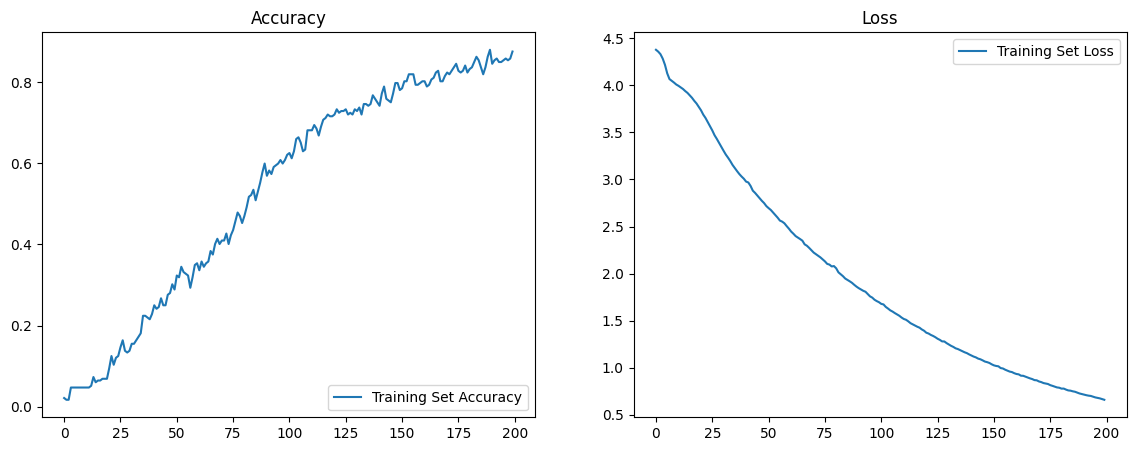

In [35]:
# Plotting model Accuracy and Loss (Visualization of the Result Plot of Accuracy and Loss)
# Plot Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# **Chatbot Testing and Adding Voices to Chatbot**



In [76]:
# Chat Inpit
while True:
  texts_p = []
  prediction_input = input('You : ')

  # Erase punctuation and convert to small case letter
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenization and Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Output model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Finding response according data tag and playing the voice bot
  response_tag = le.inverse_transform([output])[0]
  tempResponse = random.choice(responses[response_tag])
  print("Stress Buster Bot : ", tempResponse)
  tts = gTTS(tempResponse, lang='en')

  # Save the model voice bot into the Google Drive
  tts.save('/content/drive/MyDrive/Project/NLP/Chatbot/Model/RCRA.wav')
  time.sleep(0.08)

  # Load the model voice bot from Google Drive
  ipd.display(ipd.Audio('/content/drive/MyDrive/Project/NLP/Chatbot/Model/RCRA.wav', autoplay=False))
  print("*click the button to play the voice*\n" + "="*60 + "\n")

  # Adding a response 'goodbye' so that bot can be stopped
  if response_tag == "goodbye":
    break

You : hi
1/1 [==============================] - 0s 25ms/step
Stress Buster Bot :  Hi there. What brings you here today?


*click the button to play the voice*

You : I feel sad
1/1 [==============================] - 0s 23ms/step
Stress Buster Bot :  I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?


*click the button to play the voice*

You : My friend passed away
1/1 [==============================] - 0s 25ms/step
Stress Buster Bot :  I'm sorry to hear that. If you want to talk about it. I'm here.


*click the button to play the voice*

You : Not now I guess
1/1 [==============================] - 0s 23ms/step
Stress Buster Bot :  I heard you & noted it all. See you later.


*click the button to play the voice*

You : Thank you, see you later
1/1 [==============================] - 0s 33ms/step
Stress Buster Bot :  Bye! Come back again.


*click the button to play the voice*



# **Save The Model**


In [37]:
# Save the model with the file format .h5 atau .pkl (pickle)
model.save('/content/drive/MyDrive/Project/NLP/Chatbot/Model/RCRA_chatbot_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
